In [1]:
# Import general packages
import os
import numpy as np
import matplotlib.pyplot as plt

# Import special packages
import cv2
import keras as KE
import tensorflow as tf

/Users/yashdave/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [18]:
ROOT = "/Users/yashdave/Documents/MSc/CIS579/Project/vehicle-detection/final/output"
true_folder = "true"
false_folder = "false"

images = []
labels = []

for file in os.listdir(os.path.join(ROOT, true_folder)):
    image = cv2.imread(os.path.join(ROOT, true_folder, file))
    images.append(image)
    labels.append(1)

for file in os.listdir(os.path.join(ROOT, false_folder)):
    image = cv2.imread(os.path.join(ROOT, false_folder, file))
    images.append(image)
    labels.append(0)

#### Label encoding

In [29]:
def encode(label: int):
    code = [0, 0]
    index = 0 if label == 0 else 1
    code[index] = 1.0
    return np.array(code)

encoded_labels = np.array(list(map(encode, labels)))
print(len(images))
# images = np.array(images)
# print(images.shape)

181
150528


#### Train-val-test split

In [4]:
!pip install scikit-learn -q

In [21]:
from sklearn.model_selection import train_test_split

train_images, test_images, train_labels, test_labels = train_test_split(images, encoded_labels, test_size = 0.2)
test_images, val_images, test_labels, val_labels = train_test_split(test_images, test_labels, test_size = 0.2)

# print(train_images.shape)
# print(train_labels.shape)
# print(test_images.shape)
# print(test_labels.shape)
# print(val_images.shape)
# print(val_labels.shape)

### Training a ResNet50 model

In [22]:
from tensorflow.keras.applications import ResNet50
model = ResNet50(weights = "imagenet", include_top = False, input_shape = (224, 224, 3))

for layer in model.layers:
    layer.trainable = False

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

rcnn = Sequential([
    model,
    Flatten(),
    Dense(256, activation = "relu"),
    Dropout(0.5),
    Dense(2, activation = "softmax")
], name="RCNN")

rcnn.compile(optimizer = Adam(learning_rate = 0.001), loss = "categorical_crossentropy", metrics = ["accuracy"])
rcnn.summary()

Model: "RCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 256)               25690368  
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 514       
                                                                 
Total params: 49278594 (187.98 MB)
Trainable params: 25690882 (98.00 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [25]:
# train_images = np.asarray(train_images).astype(np.float32)
# train_labels = np.asarray(train_labels).astype(np.float32)
history = rcnn.fit(train_images, train_labels, epochs = 10, 
                   batch_size = 8, validation_data = (val_images, val_labels))

rcnn.save("vehicles_rcnn.h5")

ValueError: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {"<class 'NoneType'>", "<class 'numpy.ndarray'>"}), <class 'numpy.ndarray'>

In [13]:
y_hat = rcnn.predict(test_images)

7/7 [==============================] - 24s 3s/step


In [14]:
rcnn.save("vehicles_rcnn.keras")

In [15]:
from sklearn.metrics import accuracy_score

flat_y_hat = np.array(list(map(np.argmax, y_hat)))
flat_y = np.array(list(map(np.argmax, test_labels)))
score = accuracy_score(flat_y, flat_y_hat)
print("Score:", round(score * 100, 2))

Score: 96.43


1/1 [==============================] - 1s 1s/step
Was 0 and predicted 0


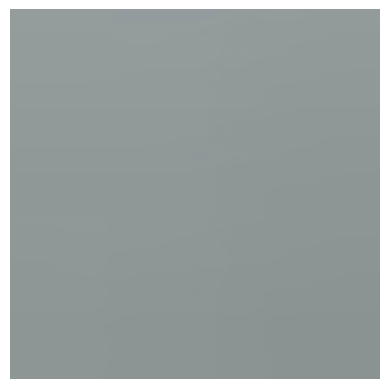

In [16]:
index = np.random.randint(0, test_images.shape[0])
y_hat = rcnn.predict(test_images[index].reshape((-1, 224, 224, 3)))

# Find label
y_hat = np.argmax(y_hat[0])
y = np.argmax(test_labels[index])
print(f"Was {y} and predicted {y_hat}")
plt.imshow(test_images[index])
plt.axis("off")
plt.show()

### Testing on a sample picture taken on mobile camera

In [1]:
import tensorflow as tf

rcnn = tf.keras.saving.load_model("vehicles_rcnn.keras")

In [2]:
def get_rects(image):
    selective_search = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    selective_search.setBaseImage(image)
    selective_search.switchToSelectiveSearchFast()
    rects = selective_search.process()
    return rects

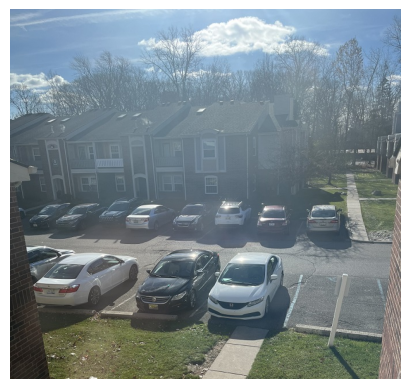

In [3]:
import cv2
import matplotlib.pyplot as plt

image = cv2.imread("data\\samples\\image.jpg", cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.axis("off")
plt.show()

In [4]:
copy = image.copy()
rects = get_rects(image)

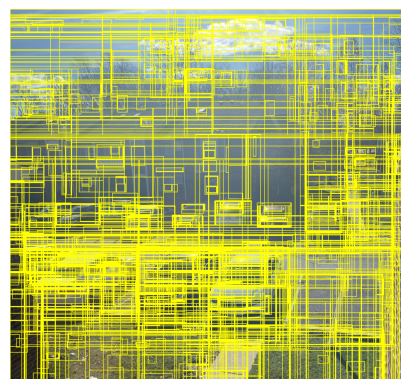

In [5]:
for rect in rects:
    x1, y1, width, height = rect
    x2 = x1 + width
    y2 = y1 + height
    cv2.rectangle(copy, (x1, y1), (x2, y2), (255, 255, 0))
    
plt.imshow(copy)
plt.axis("off")
plt.show()

In [6]:
import numpy as np

indices = np.random.randint(0, len(rects), 100)
input_rects = []

for i in indices:
    x1, y1, width, height = rects[i]
    x2 = x1 + width
    y2 = y1 + height
    input_rects.append([x1, y1, x2, y2])

In [7]:
def get_region(image, rect: [], target_shape: set = (224, 224)):
    x1, y1, x2, y2 = rect
    region = image[y1:y2, x1:x2]
    region = cv2.resize(region, target_shape)
    return region

regions = []
for rect in input_rects:
    regions.append(get_region(image, rect))

regions = np.array(regions).reshape((-1, 224, 224, 3))
print(regions.shape)

(100, 224, 224, 3)


In [8]:
predict = rcnn.predict(regions)
predict = np.array(list(map(np.argmax, predict)))

# Find rects that contains rectangles
true_indices = np.where(predict == 1)[0]

4/4 [==============================] - 19s 4s/step


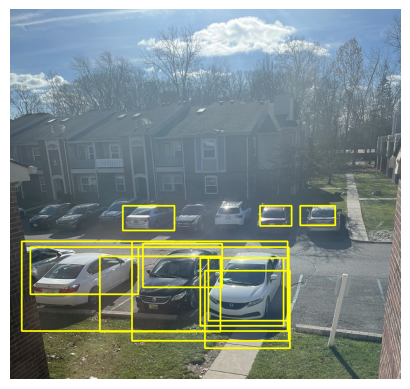

In [9]:
copy = image.copy()

for i in true_indices:
    x1, y1, x2, y2 = input_rects[i]
    cv2.rectangle(copy, (x1, y1), (x2, y2), (255, 255, 0), 2)

plt.imshow(copy)
plt.axis("off")
plt.show()

In [11]:
cv2.imwrite("output.png", cv2.cvtColor(copy, cv2.COLOR_BGR2RGB))

True